# Document Clustering and Latent Semantic Analysis

An important application of clustering is for sorting documents into groups.  In this demo, we will illustrate how to use the k-means algorithms for this task.  This example is taken mostly from one of the sklearn examples. 

Through the demo, you will learn how to:
* Represent a corpus as a set of strings
* Build a vocabulary from a corpus
* Compute the TF-IDF scores for the documents in the corpus based on the vocabulary
* Run k-means to automatically discover document clusters
* Display key terms in each document cluster
* Perform an LSA on a corpus with a sparse SVD.

## Loading the Data

First, we load the standard packages along with a number of `sklearn` sub-packages for text processing.

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import sys
from time import time

import numpy as np
import matplotlib.pyplot as plt

The [UseNet newsgroups](https://en.wikipedia.org/wiki/Usenet_newsgroup) were popular long time ago as online forums for discussing various issues.  Although they are not used much today for topic discussions, the posts from that era are still widely-used in machine learning classes for demonstrating various text processing methods.  Due to their wide use, the `sklearn` package has a built-in routine `fetch_20newsgroups` for extracting the newsgroup examples.  The code below can be used to get a subset of categories or all categories.

In [2]:
use_all_categories = False
if use_all_categories:
    categories = None
else:
    categories = [
        'alt.atheism',
        'talk.religion.misc',
        'comp.graphics',
        'sci.space',
    ]

print("Loading 20 newsgroups dataset for selected categories")
dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

Loading 20 newsgroups dataset for selected categories


We print out the categories and the number of documents in each category.  We see the `dataset` has two key fields:

* `dataset.target_names`:  The names of the categories
* `dataset.target`:  The index of the category for each post

In [3]:
categories = dataset.target_names
labels = dataset.target
ncat = len(categories)
for i in range(ncat):
    cnt = np.sum(labels == i)
    print('%-30s: %d ' % (categories[i], cnt))

alt.atheism                   : 799 
comp.graphics                 : 973 
sci.space                     : 987 
talk.religion.misc            : 628 


The data is in the `data` field of `dataset`.  Each entry `dataset.data[i]` is a string corresponding to the post to the newsgroup.  We can print an example as follows.

In [4]:
doc_ind = 20  # Index of an example document
data_ex = dataset.data[doc_ind]
cat_ex  = dataset.target_names[labels[doc_ind]]
print('Post from {0:s}'.format(cat_ex))
print()
print(data_ex)

Post from talk.religion.misc

From: agr00@ccc.amdahl.com (Anthony G Rose)
Subject: Re: Who's next?  Mormons and Jews?
Reply-To: agr00@JUTS.ccc.amdahl.com (Anthony G Rose)
Organization: Amdahl Corporation, Sunnyvale CA
Lines: 18

In article <1993Apr20.142356.456@ra.royalroads.ca> mlee@post.RoyalRoads.ca (Malcolm Lee) writes:
>
>In article <C5rLps.Fr5@world.std.com>, jhallen@world.std.com (Joseph H Allen) writes:
>|> In article <1qvk8sINN9vo@clem.handheld.com> jmd@cube.handheld.com (Jim De Arras) writes:
>|> 
>|> It was interesting to watch the 700 club today.  Pat Robertson said that the
>|> "Branch Dividians had met the firey end for worshipping their false god." He
>|> also said that this was a terrible tragedy and that the FBI really blew it.
>
>I don't necessarily agree with Pat Robertson.  Every one will be placed before
>the judgement seat eventually and judged on what we have done or failed to do
>on this earth.  God allows people to choose who and what they want to worship.

I'm

## Computing TF-IDF features

Documents are natively text.  To apply most machine learning algorithms, we need to convert the documents to vectors.  One popular method is the so-called TF-IDF score.  First, we select a set of words in the corpus.  Each word is sometimes called a *token*.  For each token `n` and document `i`, we then compute the data matrix:
      
    X[n,i] = TF-IDF score of word i in document n
           = term freq[n,i] * inverse doc frequency[i]
           
where

    term freq[n,i]  = (#occurances of word i in doc n)/(#words in doc n)  
    inverse doc freq[i] = log(#docs in corpus/#docs with word i)
        
In the data matrix `X`, each document `n` is represented by a vector `X[n,:]`.

The data matrix `X` can be computed by a *vectorizer*.  Writing an efficient vectorizer is somewhat time-consuming.  Luckily, `sklearn` has very good routines to compute the TF-IDF representations of a corpus.  We first create a `TfidfVectorizer` object:

In [5]:
vectorizer = TfidfVectorizer( 
                max_df=0.5, # max doc freq (as a fraction) of any word to include in the vocabulary
                min_df=2,   # min doc freq (as doc counts) of any word to include in the vocabulary
                max_features=10000,           # max number of words in the vocabulary
                stop_words='english',         # remove English stopwords
                use_idf=True )        # use IDF scores

Then, we create the data matrix from the dataset.

In [6]:
print("Extracting features from the training dataset using a sparse vectorizer")
t0 = time()
X = vectorizer.fit_transform(dataset.data)
print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)

Extracting features from the training dataset using a sparse vectorizer
done in 1.064554s
n_samples: 3387, n_features: 10000


We can display the terms with the highest TF-IDF scores in a post as follows.

In [7]:
doc_ind = 20  # Index of an example document
xi = X[doc_ind,:].todense()
term_ind = np.fliplr(xi.argsort())
xi_sort = xi[0,term_ind]
terms = vectorizer.get_feature_names_out()

for i in range(30):
    term = terms[term_ind[0,i]]
    tfidf = xi[0,term_ind[0,i]]
    print('{0:20s} {1:f} '.format(term, tfidf))

amdahl               0.322284 
agr00                0.239142 
robertson            0.235802 
ccc                  0.218547 
anthony              0.216653 
std                  0.199501 
com                  0.198909 
rose                 0.195249 
royalroads           0.188036 
worship              0.184182 
false                0.163750 
ca                   0.162403 
pat                  0.142662 
seat                 0.121417 
terrible             0.119571 
club                 0.117901 
tragedy              0.112468 
sunnyvale            0.111337 
commandment          0.110275 
juts                 0.109274 
700                  0.108326 
cube                 0.106573 
judged               0.104979 
said                 0.104846 
judgement            0.104234 
greatest             0.104234 
god                  0.099771 
met                  0.097624 
blew                 0.096184 
failed               0.094430 


## Run k-Means

We now run k-means on the TF-IDF vectors to try  to automatically detect clusters.  First, we construct a `kMeans` object to perform the clustering.

In [8]:
n_clusters = 4
km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1,
                verbose=True)

Then, we run the k-means clustering.  This will run through several iterations.

In [9]:
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
labelkm = km.labels_
print("done in %0.3fs" % (time() - t0))
print()

Clustering sparse data with KMeans(max_iter=100, n_clusters=4, n_init=1, verbose=True)
Initialization complete
Iteration 0, inertia 6407.814955088753.
Iteration 1, inertia 3294.8043102092656.
Iteration 2, inertia 3282.5510625698716.
Iteration 3, inertia 3278.552282004475.
Iteration 4, inertia 3276.8885553654545.
Iteration 5, inertia 3275.937481102846.
Iteration 6, inertia 3275.1746843860933.
Iteration 7, inertia 3274.615569530455.
Iteration 8, inertia 3274.2421156336245.
Iteration 9, inertia 3273.990483677035.
Iteration 10, inertia 3273.813405194344.
Iteration 11, inertia 3273.6813569156075.
Iteration 12, inertia 3273.5621085297666.
Iteration 13, inertia 3273.464094083374.
Iteration 14, inertia 3273.400083362605.
Iteration 15, inertia 3273.3284992490944.
Iteration 16, inertia 3273.2226331995003.
Iteration 17, inertia 3273.1512306584773.
Iteration 18, inertia 3273.0953821979724.
Iteration 19, inertia 3273.0721955838026.
Iteration 20, inertia 3273.053705857904.
Iteration 21, inertia 3273

To get an idea of the clusters, we print out the terms corresponding to the 10 largest components of the centroid in each cluster.  You can clearly see the clustering of topics.

In [10]:
order_centroids = np.fliplr(np.argsort(km.cluster_centers_,axis=1))
for i in range(n_clusters):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: com university article cs posting space host nntp like just
Cluster 1: god sandvik com keith people sgi morality jesus livesey kent
Cluster 2: graphics image thanks file files 3d university gif help images
Cluster 3: space henry access nasa digex toronto pat alaska shuttle gov


We next print the percentage each category appears in one of the four clusters.  We see that certain categories are mostly contained in specific clusters found by k-means.

In [11]:
cnt = np.zeros((ncat,n_clusters), dtype=int)
for i, cat in enumerate(categories):
    print('%-40s ' % cat, end='')
    for j in range(n_clusters):
        cnt[i,j] = np.sum((labelkm==j) & (labels==i))
    cntp = cnt[i,:] / np.sum(cnt[i,:])
    for j in range(n_clusters):
        print('%5.3f ' % cntp[j], end='')
    print()



alt.atheism                              0.431 0.569 0.000 0.000 
comp.graphics                            0.225 0.001 0.771 0.003 
sci.space                                0.502 0.000 0.023 0.475 
talk.religion.misc                       0.627 0.365 0.002 0.006 


## LSA Analysis

The TF-IDF matrix is typically low rank since there are usually a small number of underlying features.  

In [12]:
import scipy.sparse.linalg
U1,S1,V1 = scipy.sparse.linalg.svds(X,k=300)

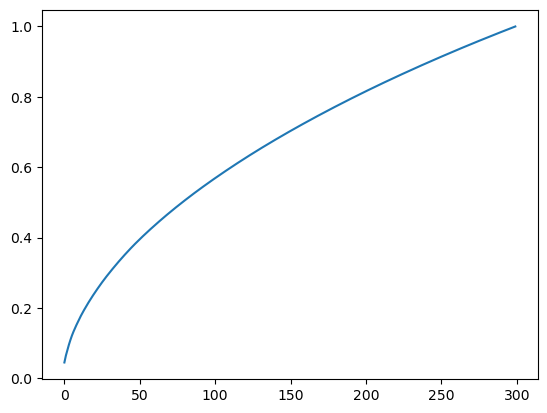

In [13]:
s = np.flipud(S1)
pov = np.cumsum(s**2) / np.sum(s**2)
plt.plot(pov)

In [14]:
from sklearn.decomposition import TruncatedSVD
pca = TruncatedSVD(n_components=100)
X_tr = pca.fit_transform(X)

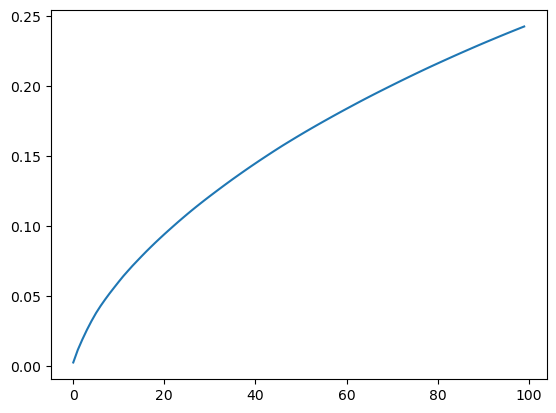

In [15]:
p = np.cumsum(pca.explained_variance_ratio_)
plt.plot(p)

In [16]:
n_clusters = 4
km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1,
                verbose=True)
km.fit(X_tr)

Initialization complete
Iteration 0, inertia 1182.510169354242.
Iteration 1, inertia 771.5826997888669.
Iteration 2, inertia 760.320423016489.
Iteration 3, inertia 754.5758001779902.
Iteration 4, inertia 753.4382720621991.
Iteration 5, inertia 752.826299255164.
Iteration 6, inertia 752.1593970254869.
Iteration 7, inertia 751.4565686248471.
Iteration 8, inertia 750.7893128150511.
Iteration 9, inertia 749.7462092202281.
Iteration 10, inertia 748.2752622523992.
Iteration 11, inertia 747.8673067055809.
Iteration 12, inertia 747.7759641808166.
Iteration 13, inertia 747.7508517566695.
Iteration 14, inertia 747.7426063168973.
Iteration 15, inertia 747.740747663295.
Iteration 16, inertia 747.7395312354329.
Converged at iteration 16: strict convergence.


KMeans(max_iter=100, n_clusters=4, n_init=1, verbose=True)

In [17]:
V = pca.inverse_transform(km.cluster_centers_)
order_centroids = np.fliplr(np.argsort(V, axis=1))
if 1:
    for i in range(n_clusters):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()

Cluster 0: sandvik kent apple newton com alink ksand cookamunga tourist private
Cluster 1: space com university graphics posting nasa article host nntp like
Cluster 2: god com people keith say sgi don morality jesus livesey
Cluster 3: access digex pat net prb hst express online communications usa


In [18]:
cnt = np.zeros((ncat,n_clusters), dtype=int)
for i, cat in enumerate(categories):
    print('%-40s ' % cat, end='')
    for j in range(n_clusters):
        cnt[i,j] = np.sum((labelkm==j) & (labels==i))
    cntp = cnt[i,:] / np.sum(cnt[i,:])
    for j in range(n_clusters):
        print('%5.3f ' % cntp[j], end='')
    print()

alt.atheism                              0.431 0.569 0.000 0.000 
comp.graphics                            0.225 0.001 0.771 0.003 
sci.space                                0.502 0.000 0.023 0.475 
talk.religion.misc                       0.627 0.365 0.002 0.006 


## Comparison of clusters to newsgroup categories

The clusters found by k-means were not based on the newsgroup category in which the post came from.  To compare the two, we create a sort of confusion matrix where:

`C[i,j] = ` fraction of cluster `j` came from newsgroup `i`.

In [19]:
labelkm = km.labels_
from sklearn.metrics import confusion_matrix
C = confusion_matrix(labels,labelkm)

Csum = np.sum(C,axis=0)
Cnorm = C / Csum[None,:]
print(Cnorm)

[[0.36697248 0.06104523 0.70374574 0.        ]
 [0.         0.42599912 0.00113507 0.01666667]
 [0.         0.38252086 0.00227015 0.95      ]
 [0.63302752 0.13043478 0.29284904 0.03333333]]


To interpret this confusion matrix, let's print out the newsgroup names:

In [20]:
dataset.target_names

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

Now, returning to the confusion matrix, we see that some discovered clusters lie almost entirely within one of the newsgroup subjects.  This is especially true for `comp.graphics` and `sci.space`.  However, some discovered clusters tend to have entries of both `alt.atheism` and `talk.religon.misc`, whose topics are likely to have a lot of overlap.

We print an example of a post that came from a newsgroup that is different from the most common newsgroup in that cluster.

In [21]:
I = np.where((labels==3) & (labelkm == 3))[0]
doc_ind = I[3]
ind_cluster = labelkm[doc_ind]
km_cat = dataset.target_names[np.argmax(Cnorm[:,ind_cluster])]

data_ex = dataset.data[doc_ind]
true_cat  = dataset.target_names[labels[doc_ind]]
print('Actual newsgroup: {0:s}'.format(true_cat))
print('Most common newsgroup in cluster:  {0:s}'.format(km_cat))
print()
print(data_ex)

Actual newsgroup: talk.religion.misc
Most common newsgroup in cluster:  sci.space

From: dickeney@access.digex.com (Dick Eney)
Subject: Re: Swastika (was: Hitler - pagan or Christian?)
Organization: Express Access Online Communications, Greenbelt, MD USA
Lines: 15
NNTP-Posting-Host: access.digex.net

The observation that the Tree of Life would rotate clockwise in the
northern hemisphere and counterclockwise in the southern probably doesn't
give enough consideration to the feebleness of the Coriolis force compared
to, say, the phototropism of vegetation.  A much more likely explanation
is the classic one: that the clockwise swastika is the Sun-wheel, because
the sun progresses across the sky that way.  (Although that's not the
historical way it happened; clocks were first made as little imitation
images of the sun moving thru the heavens.  So it's more valid to talk of
the clock going sunwise, but do the engineers listen to me?  Of course
not.)  Anyway, there is still much uncertainty a

## Latent Semantic Analysis

Another important tool in document analysis is [latent semantic analysis (LSA)](https://en.wikipedia.org/wiki/Latent_semantic_analysis).  In LSA, we simply compute an SVD of the TF-IDF matrix,

    X = U diag(S) V
    
This is equivalent to performing a PCA on `X`.  If we let `A = U diag(S)` then `X = AV`.  First, we compute the PCs of `X`.  Since `X` is a sparse matrix, it is preferable to use the sparse `svds` method in the `scipy` package.

In [22]:
import scipy.sparse.linalg
U1,S1,V1 = scipy.sparse.linalg.svds(X,k=300)

We can next plot the singular values. We see that the first few singular values are significantly larger than the remaining singular values suggesting that the term-document matrix `X` has a low rank structure.

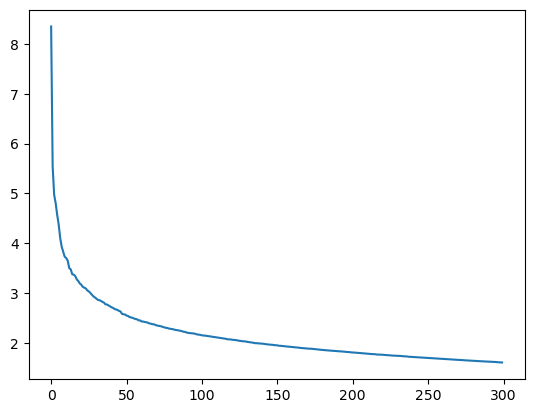

In [23]:
plt.plot(S1[::-1])

Given the low rank structure of `X`, we can write 

     X[n,i] = \sum_k A[n,k] V[k,i]
     
where the sum is over some relatively small number of components.  There are two uses for this representation:
* Word and document embeddings:  A[n,:] provides a low-dimensional vector representation of each document.  This is useful pre-processing step in many natural processing (NLP) methods.  This type of representation is closely related to an important topic of *word embeddings* and *document embeddings*.
* Topic modeling:  One interpretation of the PCA is that each PC `k` represents some common *topic* in the corpus.  Then, `A[n,k] =` the component of topic `k` in document `n` and `V[k,i]` represents the occurance of word `i` in topic `k`.

To get an idea of the words within each PC, we print the words for the largest components in the first 5 PCs.  On a small corpus like 20 newsgroups, the PCs in this case are not very useful.  But, the technique can yield more useful results in larger corpi.

In [24]:
V1sort = np.abs(V1).argsort()[:, ::-1]
for i in range(5):
    print("PC %d:" % i, end='')
    for ind in V1sort[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

PC 0: muenchen does dan bockamp targa colour shall ch uk man
PC 1: phigs government uci 3d khomeini colorado uni rh rayshade screen
PC 2: clarke asimov wesleyan values vga physics fl ed pluto tyre
PC 3: ericsson color wesleyan point program convenient boeing scott targa jpeg
PC 4: thanks muenchen format mac earth pluto color uci true ether


In [25]:
U1.shape

(3387, 300)

In [26]:
true_k = n_clusters
km = KMeans(n_clusters=true_k , init='k-means++', max_iter=100, n_init=1,
                verbose=True)
km.fit(X_tr)

Initialization complete
Iteration 0, inertia 1048.8819435290036.
Iteration 1, inertia 773.0323068023225.
Iteration 2, inertia 771.8546903029453.
Iteration 3, inertia 771.7177163210425.
Iteration 4, inertia 771.7108640240705.
Iteration 5, inertia 771.7087863689609.
Converged at iteration 5: strict convergence.


KMeans(max_iter=100, n_clusters=4, n_init=1, verbose=True)

In [27]:
V_tr =  km.cluster_centers_
V_tr.shape
V = pca.inverse_transform(V_tr)

order_centroids = np.fliplr(np.argsort(V, axis=1))

In [28]:
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: alaska nsmca aurora acad3 space fairbanks jacked adams michael high
Cluster 1: com god article space don university like people know posting
Cluster 2: buffalo cc ubvmsb weiss psyrobtw robert vnews vax vms promise
Cluster 3: access digex pat net prb hst express online communications usa
